In [1]:
## Runge Kutta

def rk4(f,y,t,h):
    
    n = len(y)                 # Number of coupled differential equations
    k1, k2, k3, k4, m = [0]*n, [0]*n, [0]*n, [0]*n , [0]*n

    for i in range(0,n): 
        
        k1[i] = h * f(y,t)[i]  # K1 calculation
        m[i] = y[i] + k1[i]/2  # Slope update 
        
    for i in range(0,n):
        
        k2[i] = h*f(m,t+h/2)[i] # K2 calculation
        m[i] = y[i] + k2[i]/2   # Slope update 
        
    for i in range(0,n):
        
        k3[i] = h*f(m,t+h/2)[i] # K3 calculation
        m[i] = y[i] + k3[i]     # Slope update 
        
    for i in range(0,n): k4[i] = h*f(m,t+h)[i]  # K4 calculation
        
    return [y[i] + (k1[i] + 2*k2[i] + 2*k3[i] + k4[i])/6 for i in range(0,n)] 

## Euler method

def euler(f,y,t,h):
    
    n = len(y)
    yhalf = [0]*n
    
    for i in range(0,n):
        
        yhalf[i] = y[i] + 0.5 * h * f(y,t)[i]
        thalf = t + 0.5*h
    
    return [ y[i] + h*f(yhalf,thalf)[i] for i in range(0,n)]



In [2]:
import numpy as np
import matplotlib.pyplot as plt

def Get_Solutions(dt,T_end,β,γ,N,method):
    
    fun = lambda y,t : [-β*y[1]*y[0]/N , β*y[1]*y[0]/N - γ*y[1] , γ*y[1]]   # Differential Equations
    
    y = [N-1,1,0]               # Initial conditions
    dt = dt                     # Time step
    T = np.arange(0,T_end,dt)   # Time interval, in days
    
    S,I,R = [],[],[]
    
    for i in T:
        
        if method == "RK4":      y = rk4(fun,y,i,dt)            
        elif method == "Euler":  y = euler(fun,y,i,dt)
        
        S.append( y[0] ) ; I.append( y[1] ) ; R.append( y[2] )
    
    # Linear interpolation

    def Funcionalization(List):
        
        def Fun(t):
            
            tt = []
            for t in t:
                
                if  len(np.where( np.abs(T-t) < dt/2)[0]) == 0 : pass 
                else: i = np.where( np.abs(T-t) < dt/2 )[0][0]
                
                try:
                    if T[i] - t > 0:   Val = (T[i] - t)*List[i-1] + (t-T[i-1])*List[i]
                    else:              Val = (T[i+1] - t)*List[i] + (t-T[i])*List[i+1]
                except IndexError:     Val = List[i]*dt
                    
                Val = Val/dt
                tt.append(Val)           

            return tt
        
        return Fun
              
    Healthy = Funcionalization(S)
    Infected = Funcionalization(I)
    Recovered = Funcionalization(R)
      
    return Healthy,Infected,Recovered
            

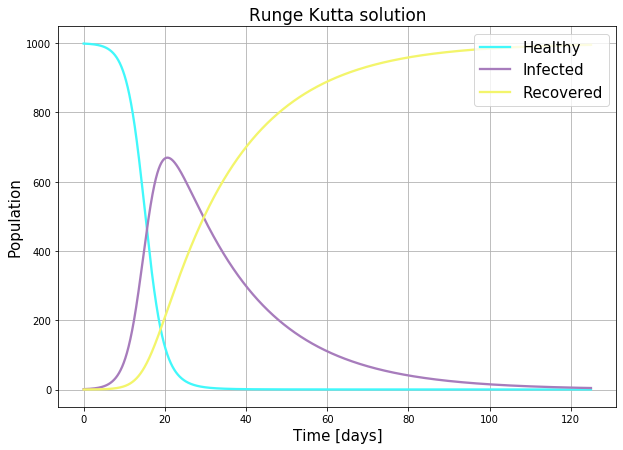

In [17]:
dt, T_end = 0.01, 125
T = np.arange(0,T_end,dt)

Sr, Ir, Rr = Get_Solutions(dt, T_end , β = 0.5,γ = 0.05,N = 1000,  method = "RK4")
fig =  plt.figure(figsize = [10,7])

plt.plot(T,Sr(T),label = "Healthy", color = "#41F8FB", lw = 2.3)
plt.plot(T,Ir(T), label = "Infected", color = "#A77CBC", lw = 2.3)
plt.plot(T,Rr(T), label = "Recovered", color = "#F3F56B", lw = 2.3)

plt.legend(loc = "upper right", fontsize = 15)
plt.xlabel("Time [days]", fontsize = 15)
plt.ylabel("Population", fontsize = 15)
plt.title("Runge Kutta solution", fontsize = 17)
plt.grid()
plt.show()

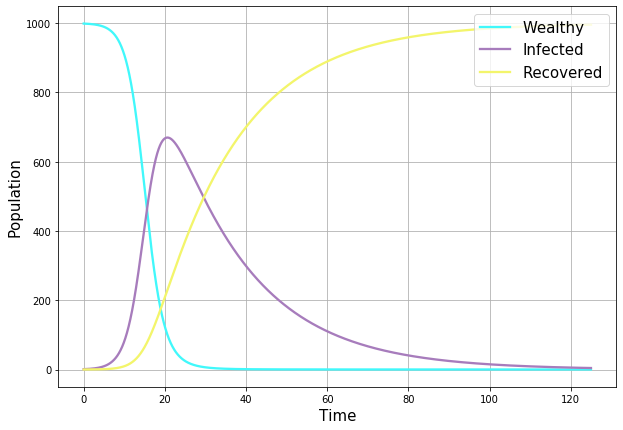

In [4]:
Se, Ie, Re = Get_Solutions(dt,T_end, β = 0.5,γ = 0.05,N = 1000, method = "Euler")

fig =  plt.figure(figsize = [10,7])

plt.plot(T,Se(T),label = "Wealthy", color = "#41F8FB", lw = 2.3)
plt.plot(T,Ie(T), label = "Infected", color = "#A77CBC", lw = 2.3)
plt.plot(T,Re(T), label = "Recovered", color = "#F3F56B", lw = 2.3)

plt.legend(loc = "upper right", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Population", fontsize = 15)
plt.title("Euler solution", fontsize = 17)
plt.grid()
plt.show()

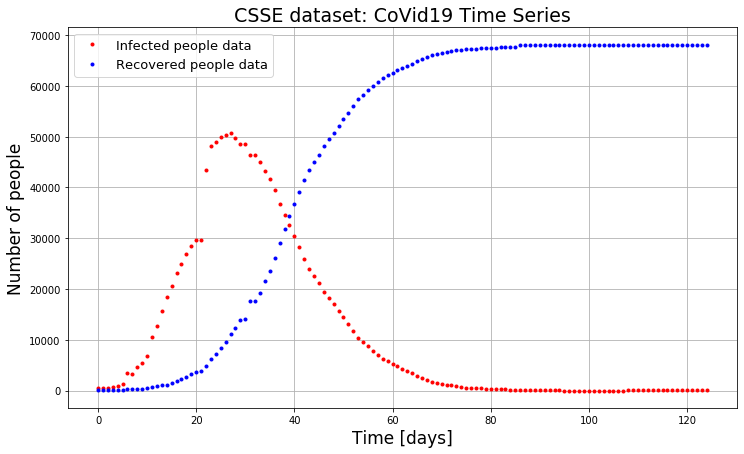

In [11]:
# Data

import pandas as pd

Deaths_data = pd.read_csv("Deaths.csv")
Deaths_array = Deaths_data[Deaths_data["Province/State"] == "Hubei"].to_numpy()[0][4:]

Confirmed_data = pd.read_csv("Confirmed.csv")
Confirmed_array = Confirmed_data[Confirmed_data["Province/State"] == "Hubei"].to_numpy()[0][4:]

Recovered_data = pd.read_csv("Recovered.csv")
Recovered_array = Recovered_data[Recovered_data["Province/State"] == "Hubei"].to_numpy()[0][4:]

Dates = Deaths_data.columns.to_numpy()[4:]

I_exp , R_exp = Confirmed_array-Recovered_array-Deaths_array , Recovered_array + Deaths_array
T_exp = range(T_end)

fig = plt.figure(figsize = [12,7])

plt.plot(T_exp, I_exp, color = "red", ls = "", marker = ".", markersize = 6, label = "Infected people data")
plt.plot(T_exp, R_exp, color = "blue", ls = "", marker = ".", markersize = 6, label = "Recovered people data")

plt.legend(loc = "best",  fontsize = 13)

plt.xlabel("Time [days]", fontsize = 17)
plt.ylabel("Number of people", fontsize = 17)
plt.title("CSSE dataset: CoVid19 Time Series", fontsize = 19)
plt.grid()
plt.show()



In [14]:
# Optimization

import scipy.optimize as so
import numpy as np

Stacked_time = np.append( range(125),range(125) )
Stacked_data = np.append( I_exp , R_exp)
    
I_opt = lambda t_array ,β , γ , N : Get_Solutions(dt, T_end, β, γ, N, method = "RK4")[1](t_array)
R_opt = lambda t_array ,β , γ , N : Get_Solutions(dt, T_end, β, γ, N, method = "RK4")[2](t_array)

def Opt_Func(t ,β , γ , N ):
    
    ext1 = t[:len(I_exp)] 
    ext2 = t[len(R_exp):] 
    
    return np.append( I_opt(ext1 ,β , γ , N) , R_opt(ext2 ,β , γ , N))

(βopt,γopt,Nopt), _ = so.curve_fit(Opt_Func, Stacked_time, Stacked_data, bounds = ([0.3,0,6.5e4], [0.7.5,0.1,8e4]))

print (βopt , γopt , Nopt)

0.5875351472536623 0.04840681751384321 70135.13066559382


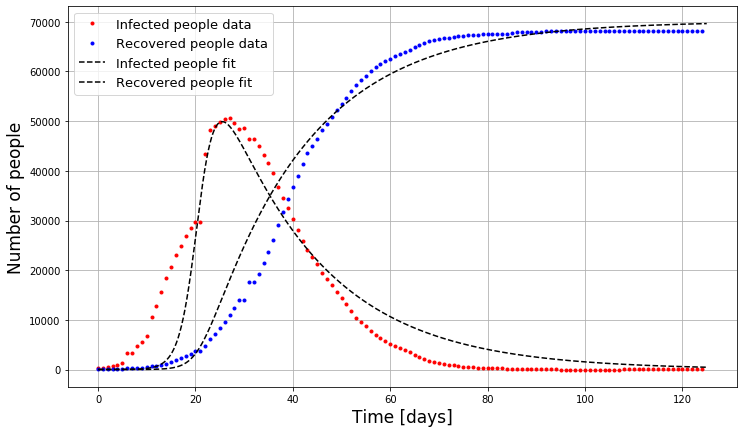

In [18]:
H,I,R = Get_Solutions(dt,T_end, βopt,γopt, Nopt, method = "RK4")

T = np.arange(0,T_end,dt)

fig = plt.figure(figsize = [12,7])

plt.plot(T_exp, I_exp, color = "red", ls = "", marker = ".", markersize = 6, label = "Infected people data")
plt.plot(T_exp, R_exp, color = "blue", ls = "", marker = ".", markersize = 6, label = "Recovered people data")

plt.plot(T,I(T), color = "k", ls = "--", label = "Infected people fit")
plt.plot(T,R(T), color = "k", ls = "--", label = "Recovered people fit")

plt.legend(loc = "best",  fontsize = 13)

plt.xlabel("Time [days]", fontsize = 17)
plt.ylabel("Number of people", fontsize = 17)
plt.grid()
plt.show()

